# Pre Stuff

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
!ls

In [0]:
import os
os.chdir("drive/My Drive//SCHOOL/Master/5an/Artificiell intelligens/AI Projekt/App/")

In [0]:
!ls

# Imports

In [0]:
textfile = 'mini_classes.txt'

In [0]:
f = open(textfile)
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
tf.test.gpu_device_name()

## Download the dataset

We only use 100 classes of the dataset. Each class is a numpy array of the shape [N,784], N is the number of images for that class.

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Load the data

## 5000 images per classes

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load a subset of the data to memory 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #separate into training and testing 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

### Tests

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [0]:
print(len(x_train))

hammer


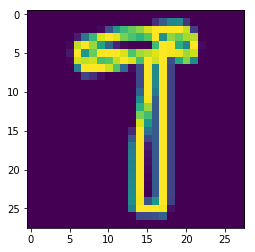

In [13]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

Model vill take batches of the shape [N, 28, 28, 1] and outputs probabilities of the shape [N, 100]

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create the Model

The simpler the model with lesser number of parameters the better. Following model contains 3 conv layers and 2 dense layers. 

In [15]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
____

# Training - Fit, Validate and Test

We train the model for 5 epochs and 256 batches with 10% validation split

## Training

In [16]:
#fit the model 
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 360000 samples, validate on 40000 samples
Epoch 1/5
360000/360000 - 17s - loss: 1.8319 - top_k_categorical_accuracy: 0.7972 - val_loss: 1.3320 - val_top_k_categorical_accuracy: 0.8815
Epoch 2/5
360000/360000 - 16s - loss: 1.1951 - top_k_categorical_accuracy: 0.8990 - val_loss: 1.1370 - val_top_k_categorical_accuracy: 0.9034
Epoch 3/5
360000/360000 - 16s - loss: 1.0479 - top_k_categorical_accuracy: 0.9141 - val_loss: 1.0224 - val_top_k_categorical_accuracy: 0.9157
Epoch 4/5
360000/360000 - 16s - loss: 0.9691 - top_k_categorical_accuracy: 0.9223 - val_loss: 0.9738 - val_top_k_categorical_accuracy: 0.9206
Epoch 5/5
360000/360000 - 16s - loss: 0.9157 - top_k_categorical_accuracy: 0.9275 - val_loss: 0.9574 - val_top_k_categorical_accuracy: 0.9220


## Testing

In [17]:
#evaluate on unseen data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.25%


## Inference

['book', 'bed', 'shorts', 'camera', 'radio']


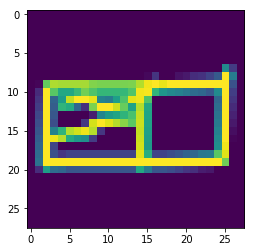

In [18]:

import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

## Store the classes

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Prepare the model for Web Format

## Behöver ej göra om

In [1]:
pip install tensorflowjs==1.2.6

In [0]:
pip install -U ipython

## Save and convert

In [20]:
model.save('keras.h5')

In [0]:
!tensorflowjs_converter --input_format keras keras.h5 model/

## Zip and download

In [0]:
!cp class_names.txt model/class_names.txt

In [23]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 85%)
  adding: model/class_names.txt (deflated 41%)


In [0]:
from google.colab import files
files.download('model.zip')